In [1]:
import os
os.environ['http_proxy']=''

import numpy as np
import pandas as pd
import urllib.request as req
import matplotlib.pyplot as plt
import cv2
import gc 
from IPython.display import display, Image

In [2]:
from keras.models import Model, load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import to_categorical

Using TensorFlow backend.
/home/pk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtype

In [3]:
def identity_module(layer_in, f1x1, f3x3_in, f3x3_out, f5x5_in, f5x5_out, fpool_out):
    """Creates a convolution block of the Deep Convolution Network.
    
    Parameters:
        layer_in: input layer to the block convolutions.
        f1x1 - fpool_out: number of filters for different layers.
    Returns:
        a convolution block for the Convolution model.
    """
    # 1x1 conv
    conv1 = Conv2D(f1x1, (1,1), padding='same', activation='relu')(layer_in)
    
    # 3x3 conv
    conv3 = Conv2D(f3x3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f3x3_out, (3,3), padding='same', activation='relu')(conv3)
    
    # 5x5 conv
    conv5 = Conv2D(f5x5_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f5x5_out, (5,5), padding='same', activation='relu')(conv5)
    
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(fpool_out, (1,1), padding='same', activation='relu')(pool)
    
    # concatenate filters, assumes filters/channels last
    out_layer = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return out_layer

In [4]:
def deep_model(num_classes, input_shape):
    """Creates a Deep Convolution Network for image processing.
    
    Parameters:
        num_classes: defines the no. of output category classes of the model.
        input_shape: input shape of the array fed to the model.
    Returns:
        a convolution model which takes input_shape array.
    """
    model_input = Input(shape=input_shape)

    layer = Conv2D(32, (5,5), padding='valid', activation='relu', kernel_initializer='he_normal')(model_input)
    layer = MaxPooling2D((3,3), padding='valid')(layer)
    layer = Conv2D(96, (3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(layer)
    layer = MaxPooling2D((3,3), padding='valid')(layer)

    layer = identity_module(layer, 32, 64, 96, 32, 64, 32)
    layer = identity_module(layer, 128, 156, 192, 64, 96, 64)

    layer = MaxPooling2D((3,3), padding='valid')(layer)

    layer = identity_module(layer, 180, 256, 256, 48, 124, 96)
    layer = identity_module(layer, 256, 312, 312, 96, 124, 96)
    layer = identity_module(layer, 312, 480, 512, 192, 256, 192)
    layer = identity_module(layer, 312, 480, 512, 192, 256, 192)

    layer = MaxPooling2D((3,3), padding='valid')(layer)

    layer = identity_module(layer, 196, 256, 256, 96, 96, 128) 
    layer = identity_module(layer, 128, 128, 96, 32, 48, 64)

    layer = AveragePooling2D((2,2), padding='valid')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.5)(layer)
    layer = Flatten()(layer)

    layer = Dense(96, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dense(32, activation='relu')(layer)
    layer = Dense(num_classes, activation='softmax')(layer)

    model = Model(inputs=model_input, outputs=layer)
    return model

In [5]:
def url_image_array(url, image_id = None, retry = 0):
    """Creates an array of image extracted from the URL and stores the image in 'Images' folder.
    
    Parameters:
        url: url of the images.
        image_id: unique id of the image url.
        retry: to retry downloading image if network error occurs.
    Returns:
        an array of extracted image from the url.
    """
    try:
        temp = req.urlopen(url)
        image = np.asarray(bytearray(temp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        img_array = cv2.resize(image, dsize=(400, 600), interpolation=cv2.INTER_LINEAR)

        if not os.path.exists('Images'):
            os.makedirs('Images')
        image_path = 'Images/' + str(image_id) + '.png'
        cv2.imwrite(image_path, img_array)

        retry = 0
        return img_array
    except Exception as e:
        if retry < 10:
            retry += 1
            url_image_array(url, image_id, retry)
        else:
            return "Error"

In [6]:
def get_train_data(df, count_train = 0): 
    """Creates the array list of images to train the model.
    
    Parameters:
        df: dataframe of the url dataset.
        count_train: stored the number of processed images from the dataset.
    Returns:
        an array of the training image data and an array of their corresponding category label.
    """
    x_train = []
    y_train = []
    for _ in range(250):
        if count_train > (len(df._unit_id)-1000):
            break
        else:
            array = url_image_array(df.image_url[count_train], df._unit_id[count_train])
            count_train += 1
            if array == 'Error':
                pass
            else:
                try:
                    x_train.append(array/255)
                    y_train.append(df.category_numeric[count_train])
                except:
                    pass

    return x_train, y_train, count_train

In [7]:
def get_validation_data(df): 
    """Creates the array list of images to validate the model.
    
    Parameters:
        df: dataframe of the url dataset.
    Returns:
        an array of the validation image data and an array of their corresponding category label.
    """
    count_val = len(df._unit_id)   
    x_val = []
    y_val = []
    for i in range(1000):
        count_val -= 1
        array = url_image_array(df.image_url[count_val], df._unit_id[count_val])
        if array == 'Error':
            pass
        else:
            x_val.append(array/255)
            y_val.append(df.category_numeric[count_val])

    return x_val, y_val

In [16]:
def test_image(model, df, url = None, image = None):
    """Display the images of similar dress patterns as the images provided to the model.
    
    Parameters:
        mpdel: the trained model to predict the image category.
        df: dataframe of the dataset to isolate similar dresses.
        url: url to the test image.
        image(str/array): can be a string indicating the local address of the image or a numeric array of the image.
    """
    if url is not None:
        array = url_image_array(url)
    elif type(image) == 'str':
        array = cv2.resize(img_to_array(load_img(image)), dsize=(400, 600), interpolation=cv2.INTER_LINEAR)
    else:
        array = image
    predict = model.predict(array.reshape(1, 600, 400, 3))
    predict = predict.argmax(axis=-1)
    print(predict)
    
    plt.figure(figsize=(5, 8))
    plt.imshow((array*255).astype('uint8'), interpolation='nearest')
    plt.title("Test Image: " + "".join([key for key, value in categories.items() if value == predict]), fontsize=14)
    plt.show()
    
    print("Similar Dresses: ")
    data = df[df['category_numeric'] == predict[0]]
    for image_id in data['_unit_id']:
        try:
            display(load_img('Images/' + str(image_id) + '.png', target_size=(300, 200)))
        except Exception as e:
            pass 
     

In [9]:
df = pd.read_csv('dress_patterns.csv')

categories = {}
category_str = df.category.unique().tolist()
for i in range(len(category_str)):
    categories[category_str[i]] = i

df['category_numeric'] = df.category.replace(categories)

In [10]:
x_val, y_val = get_validation_data(df)

In [11]:
x_val = np.array(x_val)
y_val = to_categorical(y_val, num_classes=17)

In [12]:
model = None
count_train = 0

In [15]:
while count_train < (len(df._unit_id)-1000):
    x_train, y_train, count_train = get_train_data(df, count_train)
    x_train = np.array(x_train)
    y_train = to_categorical(y_train, num_classes=len(category_str))

    print(x_train.shape)

    if model == None:
        model = deep_model(17, x_train.shape[1:])
        model.summary()

    model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
    history = model.fit(x_train, y_train, epochs=75, verbose=1, batch_size=8, shuffle = True, validation_data=(x_val[1:], y_val[1:]))
    model.save("dress_pattern.h5")
    print(gc.collect())

<urlopen error [Errno -2] Name or service not known>   0
<urlopen error [Errno -2] Name or service not known>   1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


(49, 600, 400, 3)
1000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 596, 396, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 198, 132, 32) 0           conv2d_1[0][0]                   
________________________________

Train on 49 samples, validate on 999 samples
Epoch 1/25
49/49 [==============================] - 97s 2s/step - loss: 2.6596 - acc: 0.3265 - val_loss: 3.0839 - val_acc: 0.2933
Epoch 2/25
49/49 [==============================] - 68s 1s/step - loss: 1.9431 - acc: 0.4898 - val_loss: 3.0999 - val_acc: 0.2933
Epoch 3/25
49/49 [==============================] - 68s 1s/step - loss: 1.8072 - acc: 0.4490 - val_loss: 3.1625 - val_acc: 0.3113
Epoch 4/25
49/49 [==============================] - 68s 1s/step - loss: 1.8292 - acc: 0.5102 - val_loss: 3.2720 - val_acc: 0.3564
Epoch 5/25
49/49 [==============================] - 68s 1s/step - loss: 1.6717 - acc: 0.4694 - val_loss: 3.2827 - val_acc: 0.3714
Epoch 6/25
49/49 [==============================] - 68s 1s/step - loss: 1.5394 - acc: 0.4694 - val_loss: 3.3898 - val_acc: 0.3734
Epoch 7/25
49/49 [==============================] - 68s 1s/step - loss: 1.4752 - acc: 0.4490 - val_loss: 3.2311 - val_acc: 0.3574
Epoch 8/25
49/49 [===========================

ResourceExhaustedError: OOM when allocating tensor with shape[8,32,596,396] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_3/Adam/gradients/max_pooling2d_1_1/MaxPool_grad/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


[1]


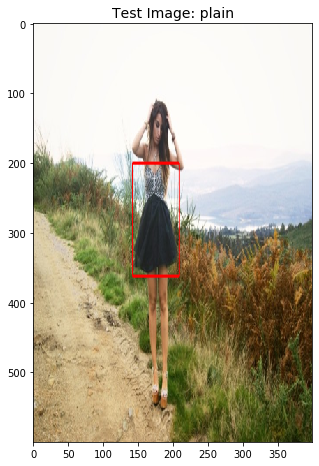

Similar Dresses: 


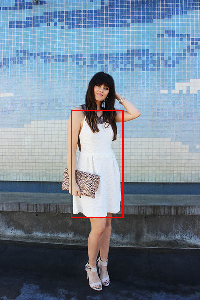

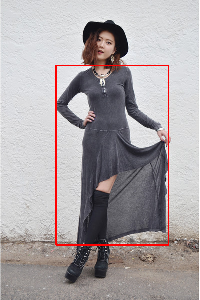

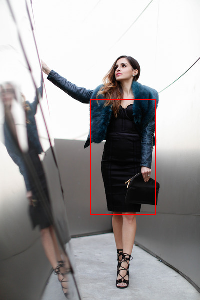

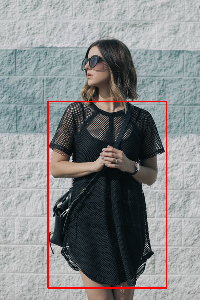

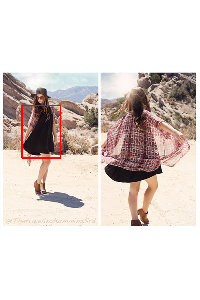

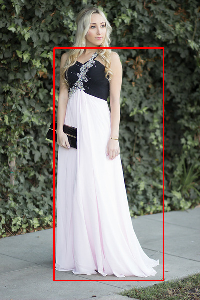

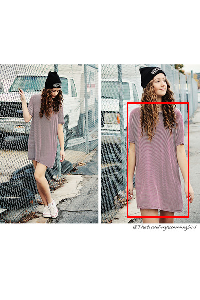

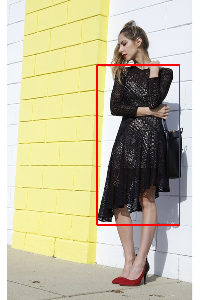

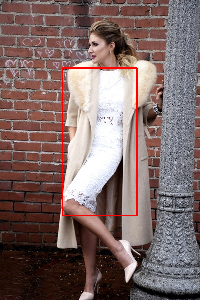

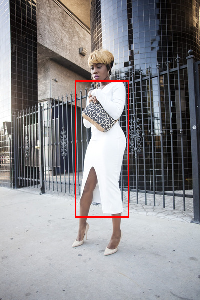

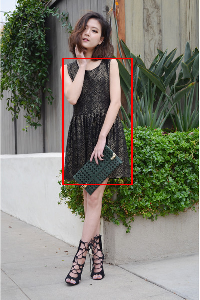

In [17]:
test_image(model, df, image = x_val[-2])